## Final Project

### Section 1 - Exploratory Data Analysis and Time Series Decomposition
In this section, you should describe the time-series variable you have selected for analysis. This should include, but is not necessarily limited to:

- Identification of the data source and brief description of the “data-generating process” based on visual analysis

- Various summary statistics of the data as necessary

- Visualizations that describe the behavior/distribution of the time-series

- Visualization and discussion of a moving average of the time series

- An assessment of seasonality using time-series decomposition and other visualizations as necessary (if seasonality is present)

- Initial split of the data into training and test sets - all following analysis conducted on training set

#### Section 1.1

Identification of the data source and brief description of the “data-generating process” based on visual analysis

The time series dataset available at https://fred.stlouisfed.org/series/WPU0811 is sourced from the Federal Reserve Economic Data (FRED) provided by the Federal Reserve Bank of St. Louis. The dataset represents the Producer Price Index (PPI) for construction materials, specifically the index for softwood lumber and related products (WPU0811). The PPI measures the average change over time in the selling prices received by domestic producers for their output, and it serves as an indicator of inflationary pressures in the production process.

The variation in the WPU0811 index can be influenced by several factors. Fluctuations in demand for construction materials, market conditions, supply chain disruptions, and changes in the cost of raw materials can contribute to variations in the index. Additionally, factors such as economic cycles, housing market trends, and trade policies may impact the prices of softwood lumber. The dataset might be challenging to forecast accurately due to the complex interplay of these factors and potential external shocks. Seasonal patterns, global economic conditions, and unforeseen events, such as natural disasters, can further complicate predictions. A thorough analysis considering both macroeconomic indicators and industry-specific factors would be crucial for developing robust forecasting models for the WPU0811 time series.

#### Data generating process
The data-generating process for this index involves the collection of prices for softwood lumber from producers, which are then aggregated and adjusted to create the index. The U.S. Bureau of Labor Statistics conducts this process as part of its broader efforts to measure changes in producer prices across various commodities and services. The index reflects the price changes from the perspective of the seller (producer), capturing the average movement in selling prices over time.

In [204]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats
import matplotlib.pyplot as plt
from tabulate import tabulate
from pandas.plotting import lag_plot
import matplotlib.dates as mdates
from IPython.display import display
from scipy.stats import boxcox
import plotly.graph_objects as go
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set_style("whitegrid")
from prophet.diagnostics import cross_validation, performance_metrics
from matplotlib.lines import Line2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.tseries.offsets import DateOffset
from datetime import timedelta
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose

In [205]:
lumber = pd.read_csv('lumber_price.csv')

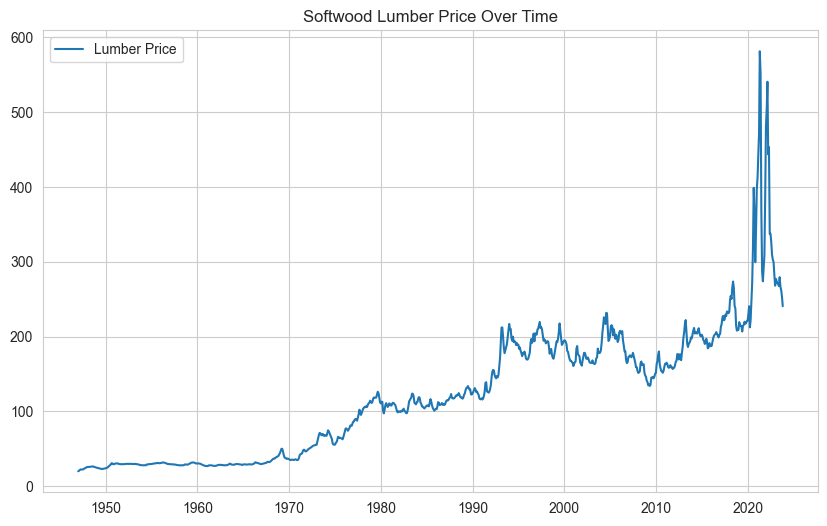

In [206]:
lumber['date'] = pd.to_datetime(lumber['date'])
plt.figure(figsize=(10, 6))
plt.plot(lumber['date'], lumber['lumber_price'], label='Lumber Price')
plt.title('Softwood Lumber Price Over Time')
plt.legend()
plt.grid(True)
plt.show()

This plot displays a general upward trend with periods of stability and intermittent peaks and troughs, indicative of market fluctuations. The most notable feature is the extreme spike in recent years, followed by a sharp decline, likely reflecting market responses to unique economic events or supply and demand shocks.

#### Section 1.2
Various summary statistics of the data as necessary

In [207]:
summary_stats = {
    'Number of Observations': len(lumber),
    'Mean': lumber['lumber_price'].mean(),
    'Median': lumber['lumber_price'].median(),
    'Mode': lumber['lumber_price'].mode()[0],  # Mode might return multiple values
    'Standard Deviation': lumber['lumber_price'].std(),
    'Minimum': lumber['lumber_price'].min(),
    'Maximum': lumber['lumber_price'].max(),
    'Range': lumber['lumber_price'].max() - lumber['lumber_price'].min()
}

# Convert the dictionary to a DataFrame for display
summary_stats_df = pd.DataFrame(summary_stats, index=[0])

# Use tabulate to create a table
summary_table = tabulate(summary_stats_df, headers='keys', tablefmt='pipe', showindex=False)

print(summary_table)

|   Number of Observations |    Mean |   Median |   Mode |   Standard Deviation |   Minimum |   Maximum |   Range |
|-------------------------:|--------:|---------:|-------:|---------------------:|----------:|----------:|--------:|
|                      923 | 120.875 |    113.2 |   27.9 |              86.5199 |      19.8 |     581.5 |   561.7 |


In [208]:
display(lumber)

,date,lumber_price
0,1947-01-01,19.800
1,1947-02-01,20.400
2,1947-03-01,21.400
3,1947-04-01,22.100
4,1947-05-01,22.300
...,...,...
918,2023-07-01,279.386
919,2023-08-01,266.602
920,2023-09-01,261.997
921,2023-10-01,253.466


- Dataset consists lumber_price from 1st February 1947 till 1st November 2023.
- The lumber price range from a low of 19.8 to a high of 581.5 with a mean of 120.875 and median of 113.2. It looks like the lumber price follow an increasing trend.

#### Section 1.3

Visualizations that describe the behavior/distribution of the time-series

In [209]:
lumber['year'] = lumber['date'].dt.year
lumber['month'] = lumber['date'].dt.month
lumber['day'] = lumber['date'].dt.day

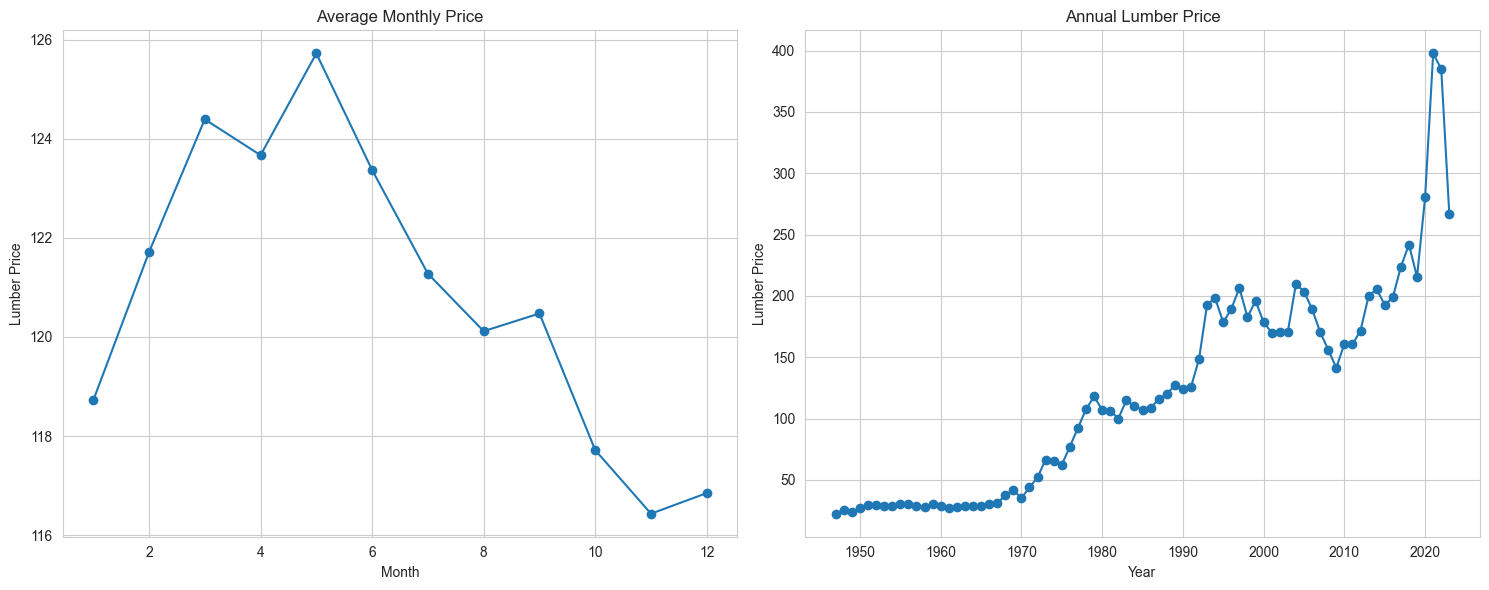

In [210]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot Monthly Sales
monthly_sales = lumber.groupby('month')['lumber_price'].mean()
axes[0].plot(monthly_sales.index, monthly_sales.values, marker='o', linestyle='-')
axes[0].set_title('Average Monthly Price')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Lumber Price')
axes[0].grid(True)

annual_sales = lumber.groupby('year')['lumber_price'].mean()
axes[1].plot(annual_sales.index, annual_sales.values, marker='o', linestyle='-')
axes[1].set_title('Annual Lumber Price')
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Lumber Price')
axes[1].grid(True)

plt.tight_layout()
plt.show()

<b>Average Monthly Price (Left-hand side plot):</b>
This plot shows the average monthly lumber prices, indicating seasonality within a year. The peak prices appear to be around the middle of the year, possibly in the summer months, which could be due to higher construction activity during warmer weather. Prices then decline towards the end of the year, which might be associated with a seasonal slowdown in construction activities during colder months.

<b>Annual Lumber Price (Right-hand side plot):</b>
The annual lumber price plot shows the average yearly price from 1950 through the 2020s. There is a long-term upward trend in the prices over the decades. The most striking feature is the sharp increase in prices in the most recent years, with a very high peak followed by a drop, suggesting a possible price bubble or a supply-driven price shock that was corrected. There are also several other smaller peaks and troughs indicating periodic fluctuations in lumber prices, which could be due to economic cycles, changes in supply and demand, policy changes, or other market factors.
Both plots are consistent with typical economic data behavior, where seasonality is present on a short-term basis (monthly), and longer-term trends and cycles are observed in the annual data. The extreme volatility in the most recent period on the annual plot would likely be a subject of interest for further economic analysis to understand the factors contributing to such dramatic price movements.

#### Section 1.4

Visualization and discussion of a moving average of the time series

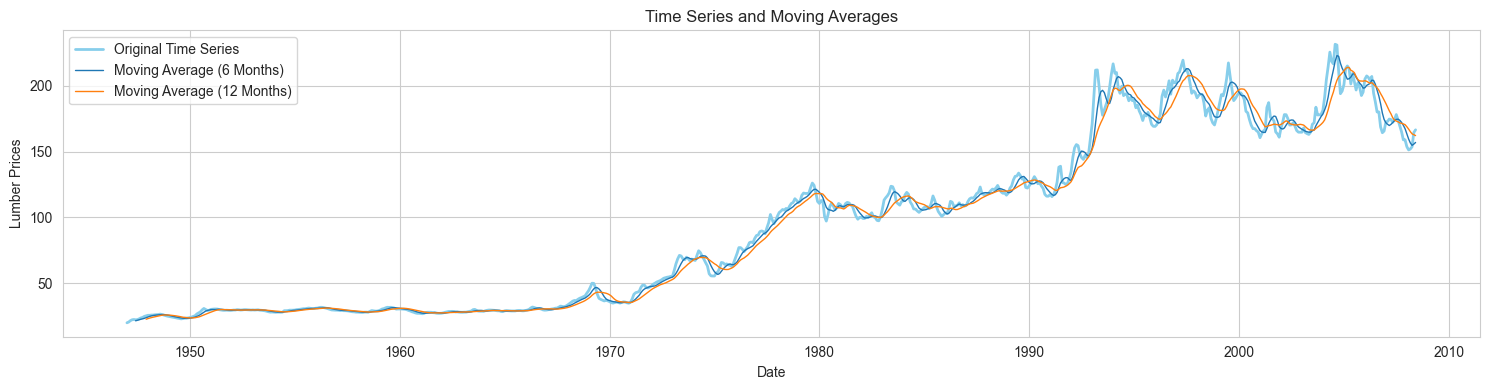

In [211]:
plt.figure(figsize=(15, 4))

window_sizes = [6,12]
plt.plot(train['date'], train['lumber_price'], label='Original Time Series', linewidth=2, color = 'skyblue')

for window_size in window_sizes :
    
    moving_average = train['lumber_price'].rolling(window=window_size).mean()
    plt.plot(train['date'], moving_average, label=f'Moving Average ({window_size} Months)', linewidth=1, linestyle = "-")

    plt.title('Time Series and Moving Averages')
plt.xlabel('Date')
plt.ylabel('Lumber Prices')
plt.legend()
plt.tight_layout()
plt.show()

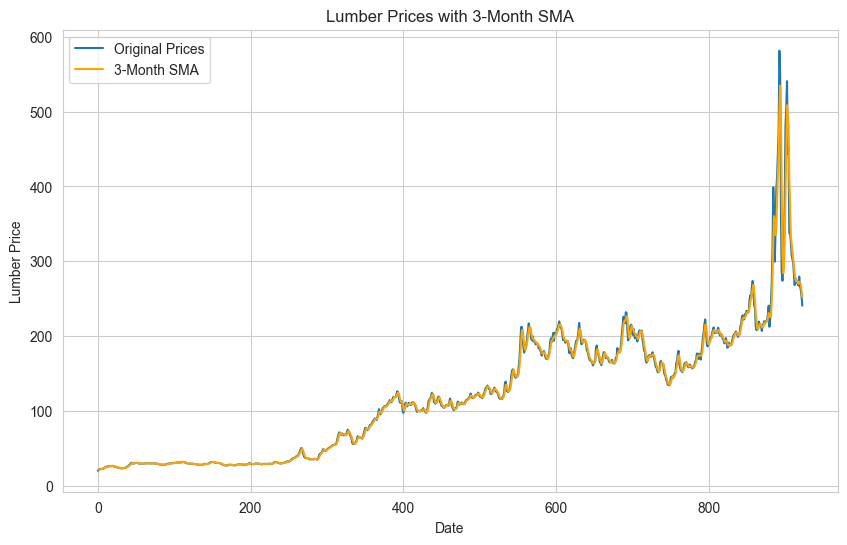

In [212]:
lumber['3_month_SMA'] = lumber['lumber_price'].rolling(window=3).mean()
plt.figure(figsize=(10, 6))
plt.plot(lumber['lumber_price'], label='Original Prices')
plt.plot(lumber['3_month_SMA'], label='3-Month SMA', color='orange')
plt.title('Lumber Prices with 3-Month SMA')
plt.xlabel('Date')
plt.ylabel('Lumber Price')
plt.legend()
plt.show()

- SMA line smooths out short-term fluctuations and highlights longer-term trends in the data.SMA is not smoothing the data as much as desired, indicating that the data still contains a lot of noise.
- A longer window for the SMA might be necessary to achieve a smoother representation of the trend.

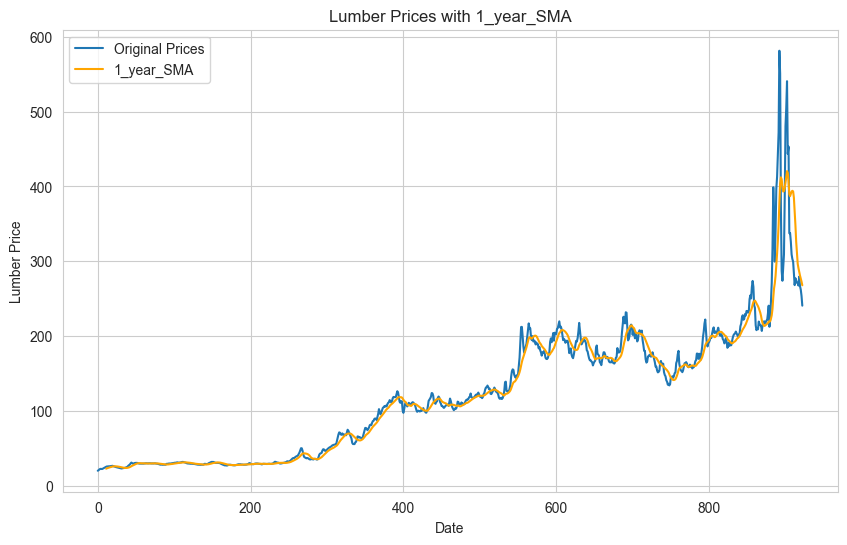

In [213]:
lumber['1_year_SMA'] = lumber['lumber_price'].rolling(window=12).mean()

plt.figure(figsize=(10, 6))
plt.plot(lumber['lumber_price'], label='Original Prices')
plt.plot(lumber['1_year_SMA'], label='1_year_SMA', color='orange')
plt.title('Lumber Prices with 1_year_SMA')
plt.xlabel('Date')
plt.ylabel('Lumber Price')
plt.legend()
plt.show()

- The 1 year SMA smooths out the data, showing the long-term trend more clearly.
- There is an overall increasing trend in lumber prices, with significant volatility and a sharp peak towards the end.

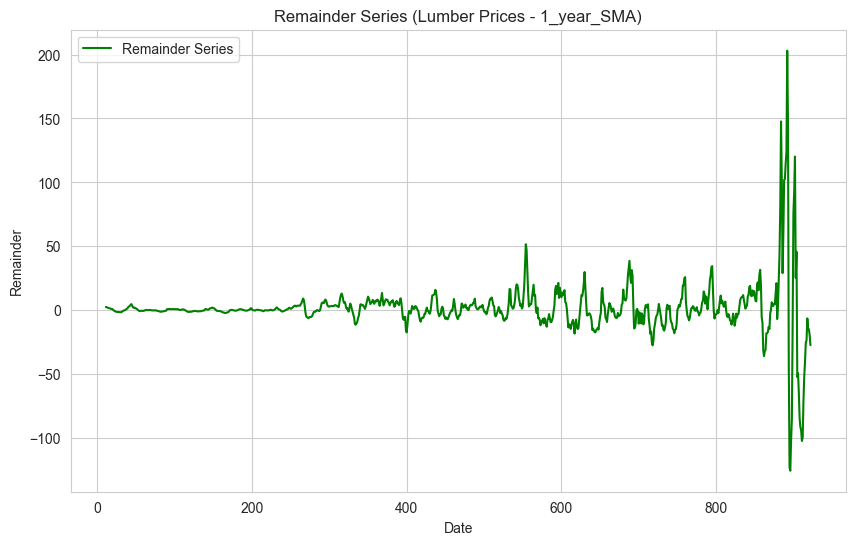

In [214]:
lumber['remainder'] = lumber['lumber_price'] - lumber['1_year_SMA']

plt.figure(figsize=(10, 6))
plt.plot(lumber.index, lumber['remainder'], label='Remainder Series', color='green')
plt.title('Remainder Series (Lumber Prices - 1_year_SMA)')
plt.xlabel('Date')
plt.ylabel('Remainder')
plt.legend()
plt.show()

- The residuals are mostly centered around zero, indicating a good fit for the model.
- But there are noticeable spikes towards the end, which could indicate model inadequacies or extraordinary events during that time.

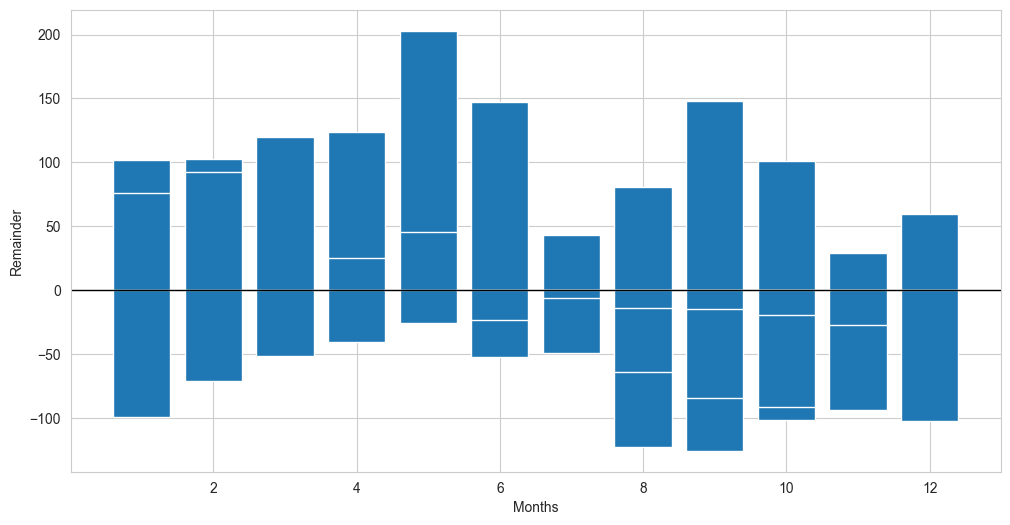

In [216]:
plt.figure(figsize=(12, 6))
plt.bar(lumber['month'], lumber['remainder'])
plt.axhline(y=0, color='black', linewidth=1, label='Zero Line')
plt.xlabel("Months")
plt.ylabel("Remainder")
plt.show()

- The residuals fluctuate above and below the zero line, indicating the differences between the actual and the estimated (trend + seasonal) values.

#### Section 1.5

An assessment of seasonality using time-series decomposition and other visualizations as necessary (if seasonality is present)

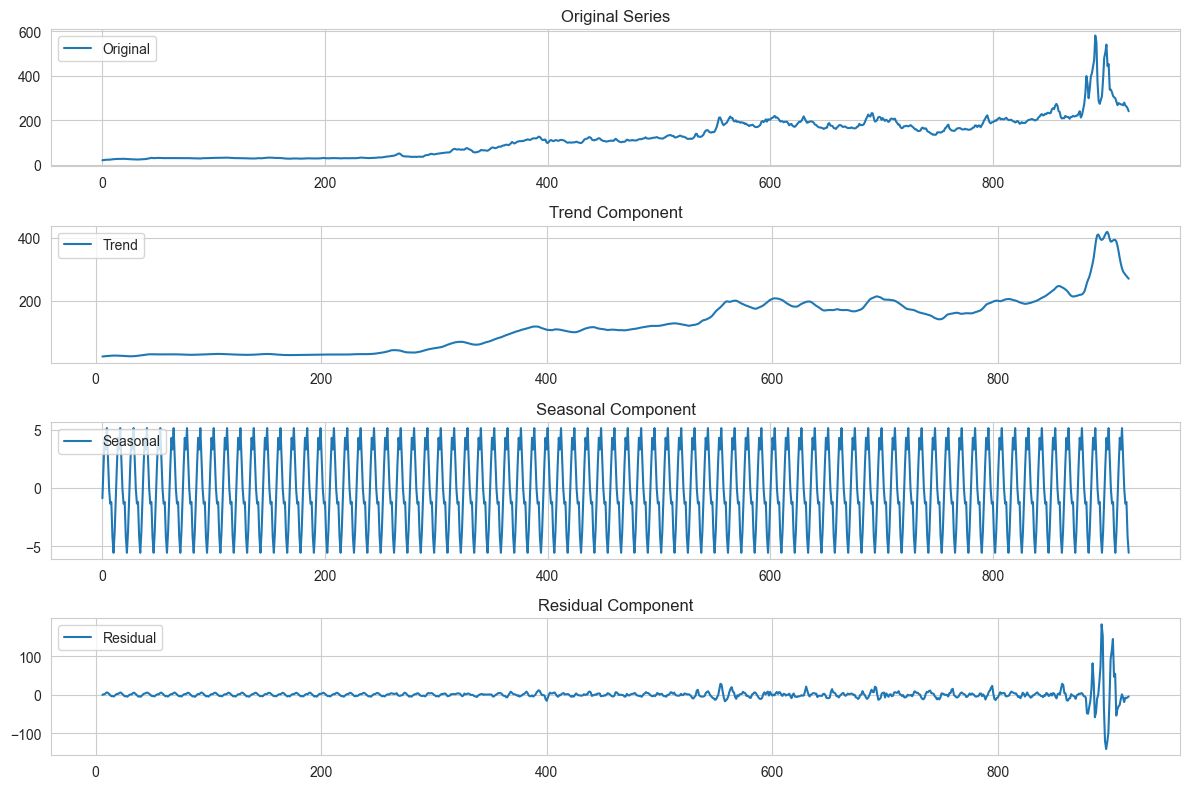

In [217]:
decomposition = seasonal_decompose(lumber['lumber_price'].dropna(), model='additive', period=12)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(lumber['lumber_price'], label='Original')
plt.legend(loc='upper left')
plt.title('Original Series')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper left')
plt.title('Trend Component')

plt.subplot(413)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

plt.subplot(414)
plt.plot(residual, label='Residual')
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()

- The seasonality appears to be strong and consistent over time, as indicated by the regular and repeated patterns in the seasonal component of the decomposition
- A long-term increasing trend in the data, with some leveling around the year 2000 and a sharp increase around 2020.
- A clear seasonal pattern that repeats consistently over time.
- Residuals that are relatively small and random, indicating a good fit, except for a large spike around 2020, which suggests an anomaly or event not captured by the model.

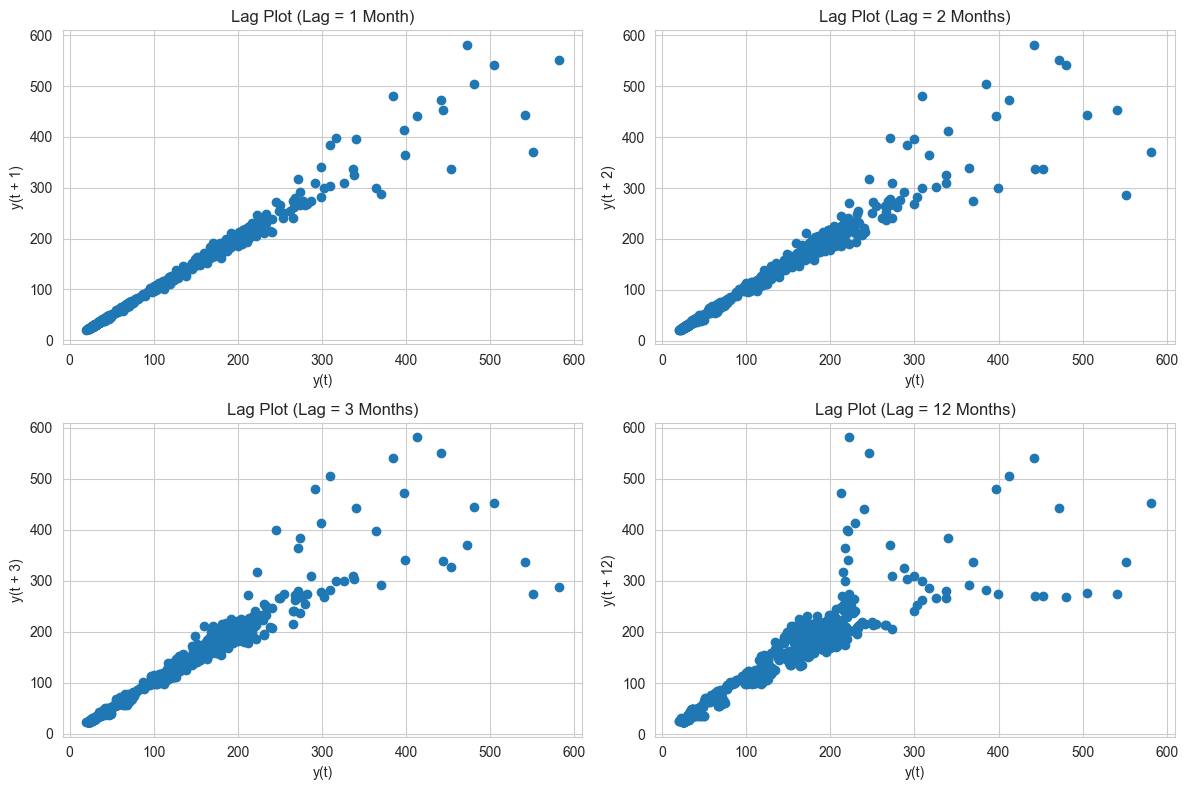

In [218]:
from pandas.plotting import lag_plot


lag_values = [1, 2, 3, 12] 
plt.figure(figsize=(12, 8))

for i, lag in enumerate(lag_values, 1):
    plt.subplot(2, 2, i)
    lag_plot(lumber['lumber_price'], lag=lag)
    plt.title(f'Lag Plot (Lag = {lag} Month{"s" if lag > 1 else ""})')

plt.tight_layout()
plt.show()

- These lag plots suggest that the time series is not random and exhibits both autocorrelation and potential seasonality.
- The strong autocorrelation at shorter lags (1 and 2 months) would be typical of a time series with a trend or momentum.
- The lag 12 months plot suggests there may be a yearly cycle or seasonal effect in the data.
- The lag plots show a strong positive correlation, especially for the initial lags.
- As the lag increases, the correlation seems to weaken slightly but remains positive.

#### Section 1.6

Initial split of the data into training and test sets - all following analysis conducted on training set

In [219]:
lumber = pd.read_csv("lumber_price.csv", parse_dates=['date'])

# Ensure 'date' is in datetime format (this might be redundant if 'parse_dates' is already used)
lumber['date'] = pd.to_datetime(lumber['date'])

# Sort the data by date to ensure correct splitting
lumber.sort_values('date', inplace=True)

# Split the data into 80% train and 20% test sets based on time
split_point = int(len(lumber) * 0.8)
train = lumber.iloc[:split_point]
test = lumber.iloc[split_point:]

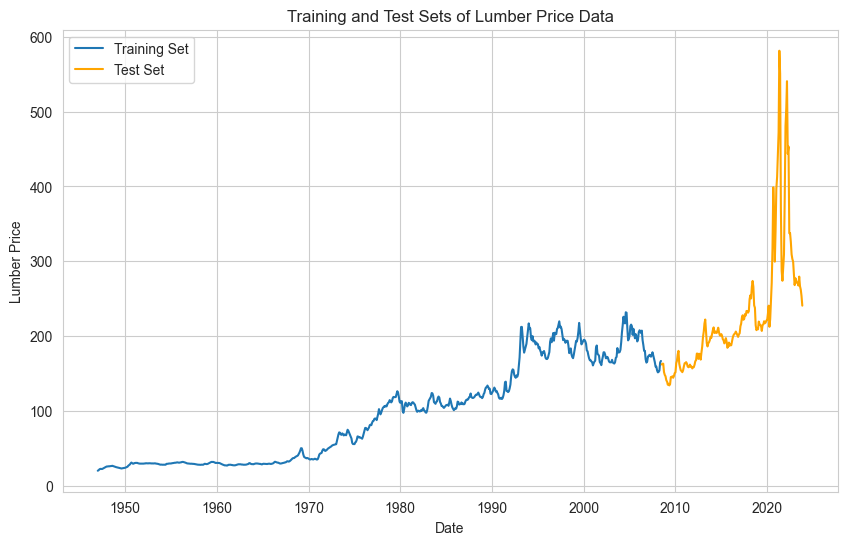

In [220]:
plt.figure(figsize=(10, 6))
plt.plot(train['date'], train['lumber_price'], label='Training Set')
plt.plot(test['date'], test['lumber_price'], label='Test Set', color='orange')

plt.title('Training and Test Sets of Lumber Price Data')
plt.xlabel('Date')
plt.ylabel('Lumber Price')
plt.legend()
plt.show()

### Section 2 - ARIMA Modeling
The second section is focused on building an ARIMA model to your time-series. This section should include, but is not necessarily limited to:

- Assessment of whether the data are variance/mean stationary using analysis of the variance over time and statistical tests such as KPSS

- Transformations of the data to induce variance/mean stationarity (log/Box-Cox and differencing) or to remove seasonality (seasonal differencing)

- Examination of ACF/PACF plots for assessment of potential ARIMA models to fit

- Selection of an appropriate ARIMA model based on AIC/BIC

- Analysis of model residuals, to include appropriate tests for residual autocorrelation (Ljung-Box)

#### Section 2.1

Assessment of whether the data are variance/mean stationary using analysis of the variance over time and statistical tests such as KPSS

In [221]:
train_arima = train.copy()
# Converting 'date' column to datetime format for easier handling
train_arima['date'] = pd.to_datetime(train_arima['date'])

# Adding a year column for segmenting the data by decades
train_arima['year'] = train_arima['date'].dt.year

# Segmenting the data by decades
decades = (train_arima['year'] // 10) * 10
segments = train_arima.groupby(decades)

# Calculating summary statistics for each segment (decade)
summary_stats = segments['lumber_price'].agg(['mean', 'var']).rename(columns={'mean': 'Mean Price', 'var': 'Variance'})

summary_stats

,Mean Price,Variance
year,,
1940,23.944444,2.780825
1950,29.288333,1.950787
1960,31.155000,23.906866
1970,72.144167,675.066688
1980,111.789167,72.204840
1990,174.232500,915.669271
2000,181.432353,359.288943


- Mean Price: There’s a clear upward trend in the mean price of lumber from the 1940s through the 2020s, indicating that the mean of the series is not stationary. The prices have generally increased over the decades, with a notable jump in the 2020s.

- Variance: The variance, which indicates the variability of lumber prices, has also changed significantly over time. Notably, there’s a massive increase in variance in the 1970s, followed by fluctuations in subsequent decades, and a very high variance in the 2020s. This suggests that the variance of the series is not stationary, with periods of higher volatility, especially in the most recent decade.

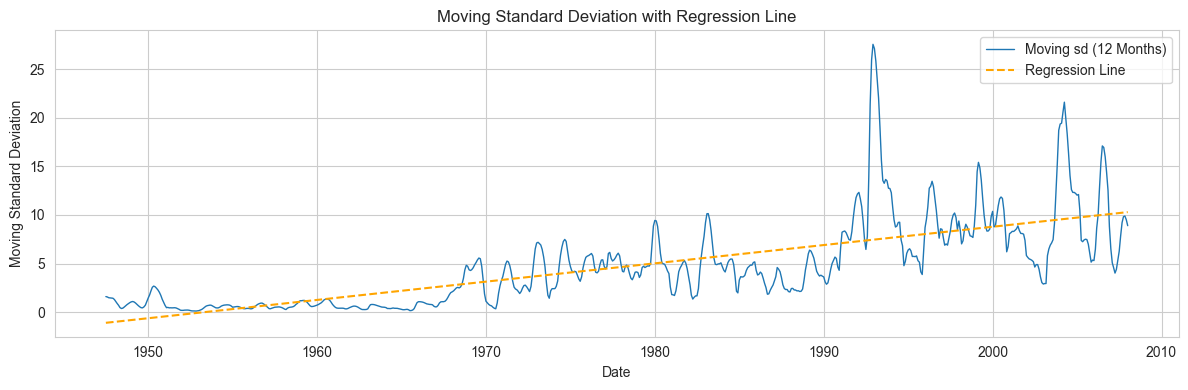

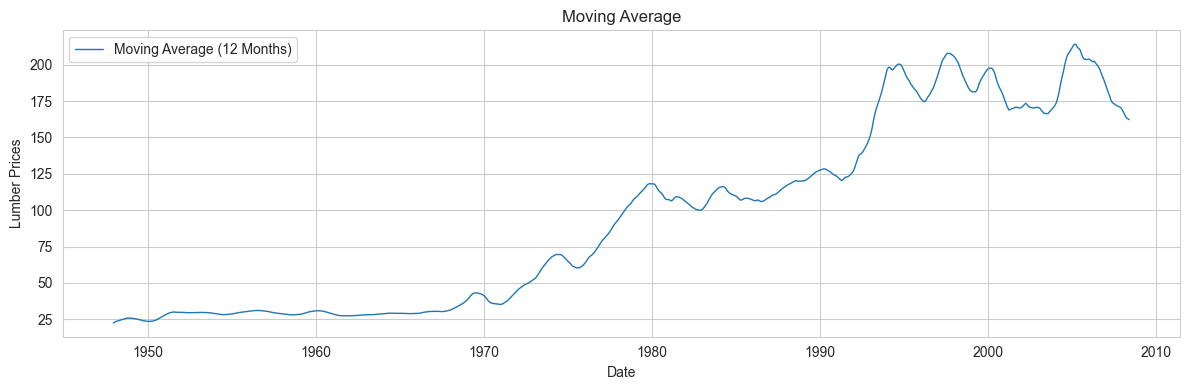

In [222]:
moving_sd = train['lumber_price'].rolling(window=12, center=True).std().dropna()
indices = moving_sd.index
aligned_dates = train['date'][indices]

plt.figure(figsize=(12, 4))
plt.plot(aligned_dates, moving_sd, label=f'Moving sd ({12} Months)', linewidth=1)
coefficients = np.polyfit(indices, moving_sd.values, 1)
linear_regression = np.polyval(coefficients, indices)
plt.plot(aligned_dates, linear_regression, label='Regression Line', linestyle='--', color='orange')
plt.legend()
plt.title('Moving Standard Deviation with Regression Line')
plt.xlabel('Date')
plt.ylabel('Moving Standard Deviation')
plt.tight_layout()
plt.show()

train['ma_12'] = moving_average
plt.figure(figsize=(12, 4))
plt.plot(train['date'], train['ma_12'], label=f'Moving Average ({window_size} Months)', linewidth=1, linestyle="-")
plt.title('Moving Average')
plt.xlabel('Date')
plt.ylabel('Lumber Prices')
plt.legend()
plt.tight_layout()
plt.show()

- It is clear that the mean lumber prices have not remained constant from 1970 to 2020. 
- Moreover, the price changes display an inconsistent pattern, signifying that the variability, or variance, is not steady across the timeframe.
- The trend demonstrated by the moving average plot points to a rising trajectory in lumber prices, indicating the absence of mean stationarity.
- Consequently, the data for lumber prices exhibit neither mean nor variance stationarity.

In [223]:
kpss_test_results = kpss(train['lumber_price'].dropna(), regression='c')

kpss_statistic = kpss_test_results[0]
p_value = kpss_test_results[1]
critical_values = kpss_test_results[3]

kpss_statistic, p_value, critical_values

(3.9273637104775676,
 0.01,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

p value is .01 which is less than 0.5, hence we need to use differenced data.

#### Section 2.2

Transformations of the data to induce variance/mean stationarity (log/Box-Cox and differencing) or to remove seasonality (seasonal differencing)

In [224]:
train['log_lumber_price'] = np.log(train['lumber_price'])
train['box_cox_lumber_price'],_ = boxcox(train['lumber_price'])

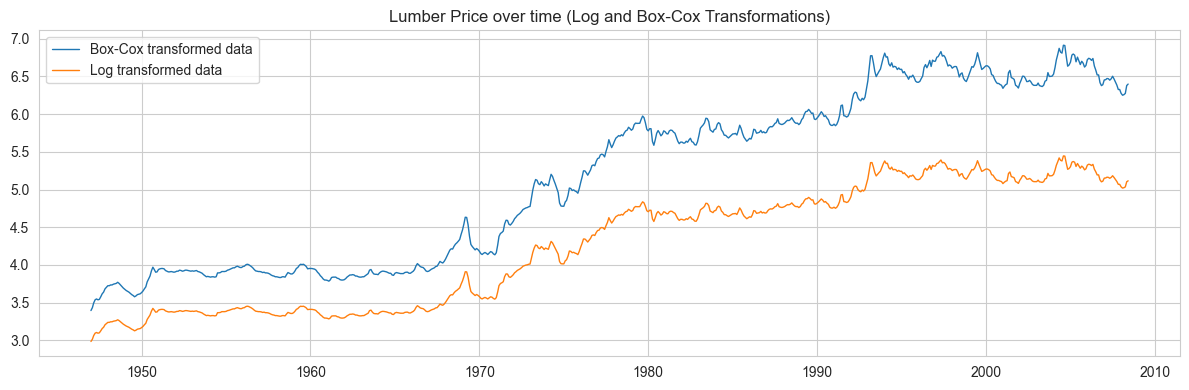

In [150]:
plt.figure(figsize=(12, 4))

plt.plot(train['date'], train['box_cox_lumber_price'], label='Box-Cox transformed data', linewidth=1)
plt.plot(train['date'], train['log_lumber_price'], label='Log transformed data', linewidth=1)

plt.legend()
plt.title("Lumber Price over time (Log and Box-Cox Transformations)")
plt.tight_layout()
plt.show()

Log transformation seems to be more effective to reduce variance.

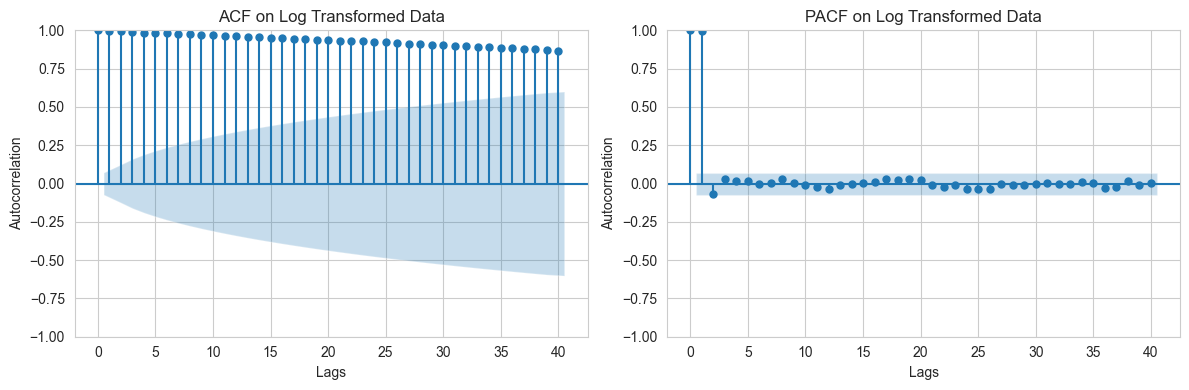

In [225]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(train['log_lumber_price'].dropna(), lags=40, title='ACF on Log Transformed Data', ax=ax1)
plot_pacf(train['log_lumber_price'].dropna(), lags=40, title='PACF on Log Transformed Data', ax=ax2)

ax1.set(xlabel="Lags", ylabel="Autocorrelation")
ax2.set(xlabel="Lags", ylabel="Autocorrelation")

plt.tight_layout()
plt.show()

In [226]:
train['differenced_data'] = train['log_lumber_price'].diff()

In [227]:
kpss_test_results = kpss(train['differenced_data'].dropna(), regression='c')

kpss_statistic = kpss_test_results[0]
p_value = kpss_test_results[1]
critical_values = kpss_test_results[3]

kpss_statistic, p_value, critical_values

(0.12886585589919775,
 0.1,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Now p values is .1 which is greater than .05, Hence the data is stationary.

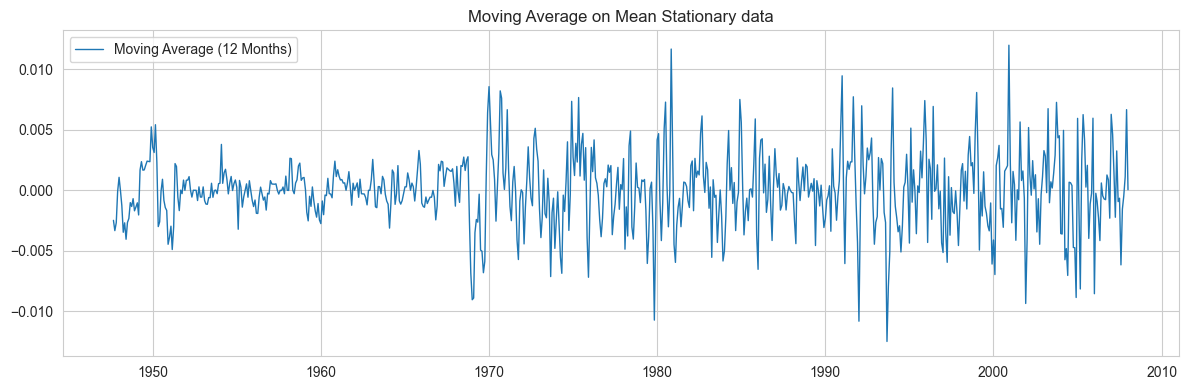

In [228]:
months = 12
moving_average = train['differenced_data'].diff().rolling(window = months, center=True).mean()

plt.figure(figsize=(12, 4))

plt.plot(train['date'], moving_average, label=f'Moving Average ({months} Months)', linewidth=1)
plt.legend()
plt.title(f"Moving Average on Mean Stationary data")
plt.tight_layout()
plt.show()

From the above model, it is confirmed that data is mean stationary.

#### Section 2.3

Examination of ACF/PACF plots for assessment of potential ARIMA models to fit

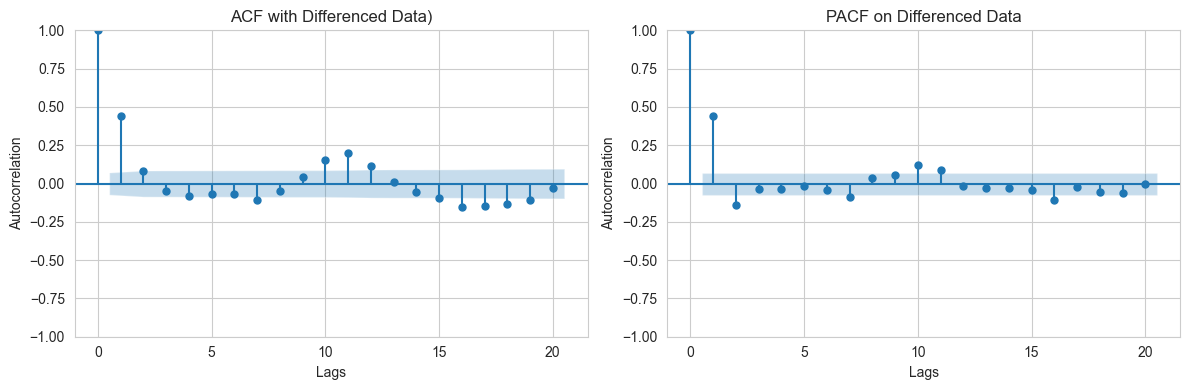

In [229]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(train['differenced_data'].dropna(), lags=20, title='ACF with Differenced Data)', ax=ax1)
plot_pacf(train['differenced_data'].dropna(), lags=20, title='PACF on Differenced Data', ax=ax2)

ax1.set(xlabel="Lags", ylabel="Autocorrelation")
ax2.set(xlabel="Lags", ylabel="Autocorrelation")

plt.tight_layout()
plt.show()

- Due to dampening effect in ACF plot above, Considering only AR process
- From the above plots: AR = 2 and d = 1 and MA = 0
- These plots shows no seasonality in the data, we can check the seasonality further with LjungBox

#### Section 2.4

Selection of an appropriate ARIMA model based on AIC/BIC

In [230]:
model_arima1 = ARIMA(train['log_lumber_price'].dropna(), order=(2,1,0), seasonal_order=(0, 0, 0, 0)).fit()
model_arima2 = ARIMA(train['log_lumber_price'].dropna(), order=(2,1,1), seasonal_order=(0, 0, 0, 0)).fit()
model_arima3 = ARIMA(train['log_lumber_price'].dropna(), order=(2,1,2), seasonal_order=(0, 0, 0, 0)).fit()

In [231]:

def fit_arima_models(data, orders):
    results_list = []

    for order in orders:
        model = ARIMA(train['log_lumber_price'], order=order[:3])
        results = model.fit()

        results_list.append({
            'Order': order,
            'BIC': results.bic,
            'AIC': results.aic
        })

    return pd.DataFrame(results_list)
orders = [(2,1,0),(2,1,1),(2,1,2)]

# Fit models and store results in a dataframe
results_df = fit_arima_models(train['log_lumber_price'], orders)

# Sort the dataframe by BIC in increasing order
results_df_sorted = results_df.sort_values(by='BIC')

# Display the sorted dataframe
display(results_df_sorted)

,Order,BIC,AIC
0,"(2, 1, 0)",-3377.106504,-3390.914268
1,"(2, 1, 1)",-3371.568115,-3389.978467
2,"(2, 1, 2)",-3365.523273,-3388.536212


In [193]:
from pmdarima.arima import auto_arima


# Fit auto ARIMA model with specified D=1
auto_model = auto_arima(train['log_lumber_price'], m=12, suppress_warnings=True,
                        stepwise=False, approximation=False, D=1)

# Get the best order
best_order = auto_model.get_params()['order']
#best_seasonal_order = auto_model.get_params()['seasonal_order']

# Extract AIC and BIC
aic_value = auto_model.aic()
bic_value = auto_model.bic()

# Print the best order, AIC, and BIC
print("Best ARIMA Order:", best_order)
#print("Best Seasonal Order:", best_seasonal_order)
print("AIC:", aic_value)
print("BIC:", bic_value)

Best ARIMA Order: (1, 0, 1)
AIC: -3307.9747540746403
BIC: -3275.8619039708665


- model_arima1 Model has better value for AIC/BIC.

#### Section 2.5

Analysis of model residuals, to include appropriate tests for residual autocorrelation (Ljung-Box)

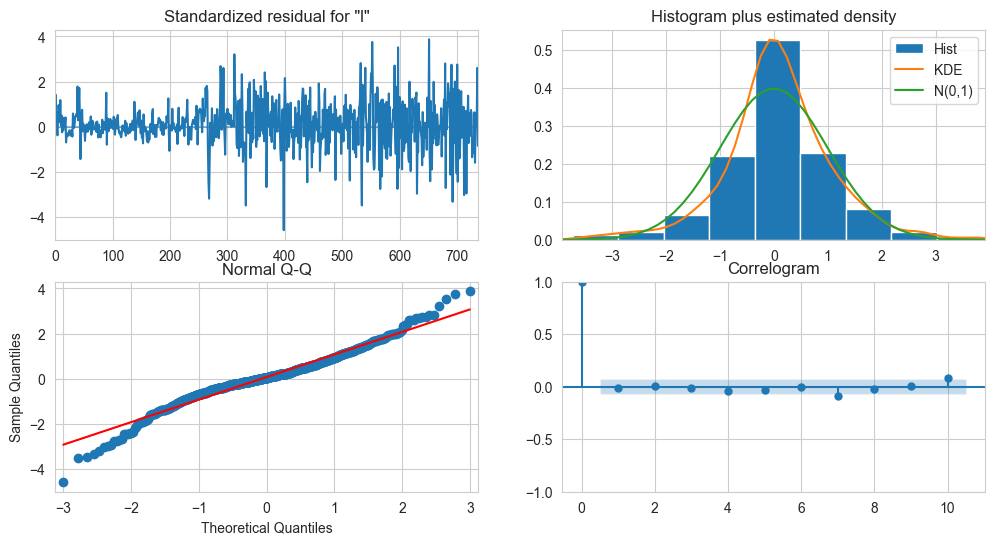

In [232]:

model_arima1.plot_diagnostics(figsize=(12, 6))
plt.show()

The diagnostic plots indicate a well-fitting ARIMA model: the residuals seem random and normally distributed, and there's no significant autocorrelation. This suggests the model's assumptions are met.

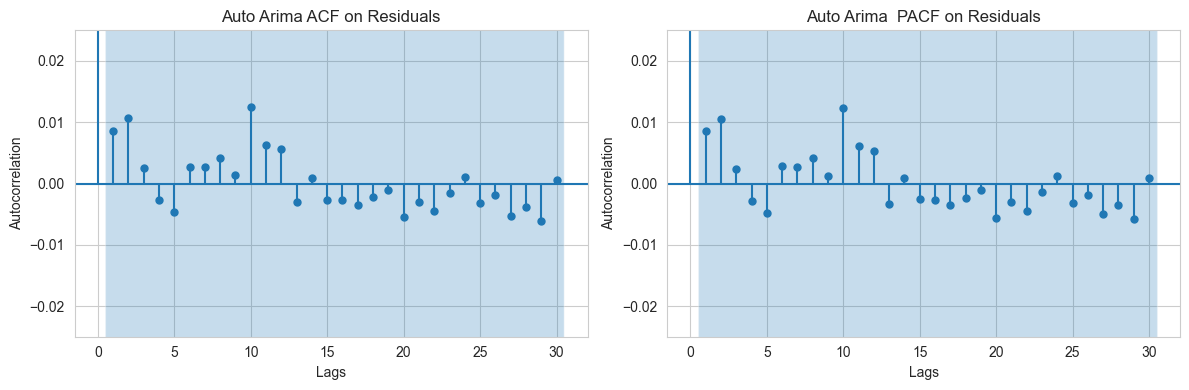

In [234]:
resid = model_arima1.resid

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(resid, lags=30, title='Auto Arima ACF on Residuals', ax=ax1)
plot_pacf(resid, lags=30, title='Auto Arima  PACF on Residuals', ax=ax2)

ax1.set(xlabel="Lags", ylabel="Autocorrelation")
ax2.set(xlabel="Lags", ylabel="Autocorrelation")
ax1.set_ylim([-0.025,0.025])
ax2.set_ylim([-0.025,0.025])

plt.tight_layout()
plt.show()

In [235]:

lumber_stats = sm.stats.acorr_ljungbox(resid, lags=12)
lumber_stats

,lb_stat,lb_pvalue
1,0.055096,0.814422
2,0.139790,0.932492
3,0.144593,0.985995
4,0.150281,0.997314
5,0.166929,0.999429
6,0.172213,0.999900
7,0.177523,0.999983
8,0.190698,0.999997
9,0.192202,1.000000
10,0.309152,0.999999


The p-values are all above 0.05, indicating that we fail to reject the null hypothesis of no autocorrelation at each lag. The ACF and PACF plots also confirm this, as the correlations are within the confidence intervals.

### Section 3 - Meta Prophet Model
The third section is focused on building a Prophet model to your time-series. This section should include, but is not necessarily limited to:

Choosing a “best” Prophet model based on assessment of:

- Decomposition of the elements of the time series (trend, seasonality, etc.) and associated visualizations

- Assessment of trend/changepoints, and modification of hyperparameters if necessary (number of changepoints, range, flexibility)

- Assessment of whether the model should take into account a saturating minimum/maximum point

- Identification and assessment of seasonality (daily, weekly, yearly, as well as additive/multiplicative), to include visualizations, as appropriate

#### Section 3.1

Decomposition of the elements of the time series (trend, seasonality, etc.) and associated visualization

In [236]:
train['date'] = pd.to_datetime(train['date'])
train_prophet = train.rename(columns={'date':'ds',
                                           'lumber_price':'y'})

model = Prophet()
model.fit(train_prophet)

future = model.make_future_dataframe(periods=24, freq='M')
forecast = model.predict(future)

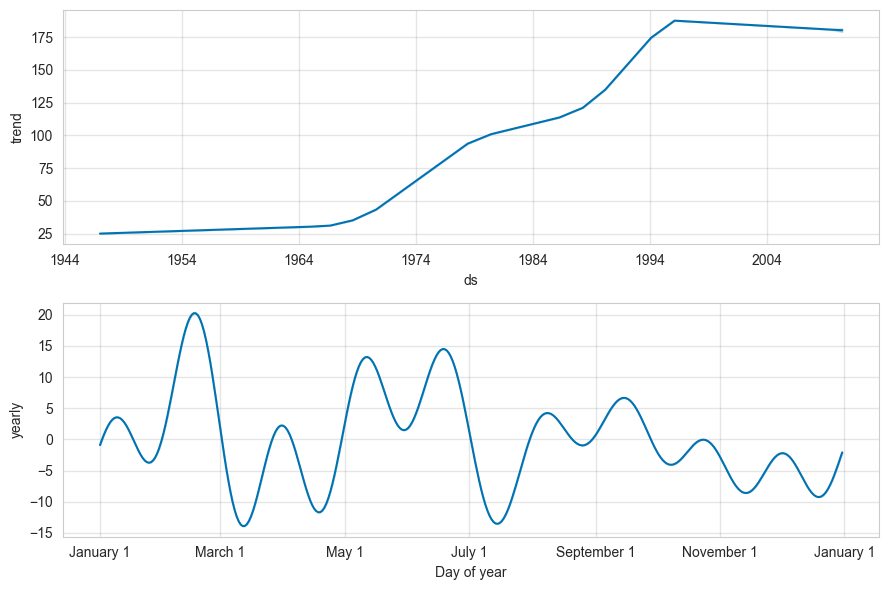

In [237]:
fig = model.plot_components(forecast)
plt.show()

- Trend: This represents the overall direction that the data is moving in over a long period. The trend shows a systematic increase or decrease in the data. In the top plot of image, the line gradually increases over time, indicating a positive trend.

- Seasonality: This represents regular and predictable patterns that repeat over time, usually within a one-year period. The bottom plot in the image shows these fluctuations, which could represent things like higher price during the holiday season or summer months.



#### Section 3.2

Assessment of trend/changepoints, and modification of hyperparameters if necessary (number of changepoints, range, flexibility)

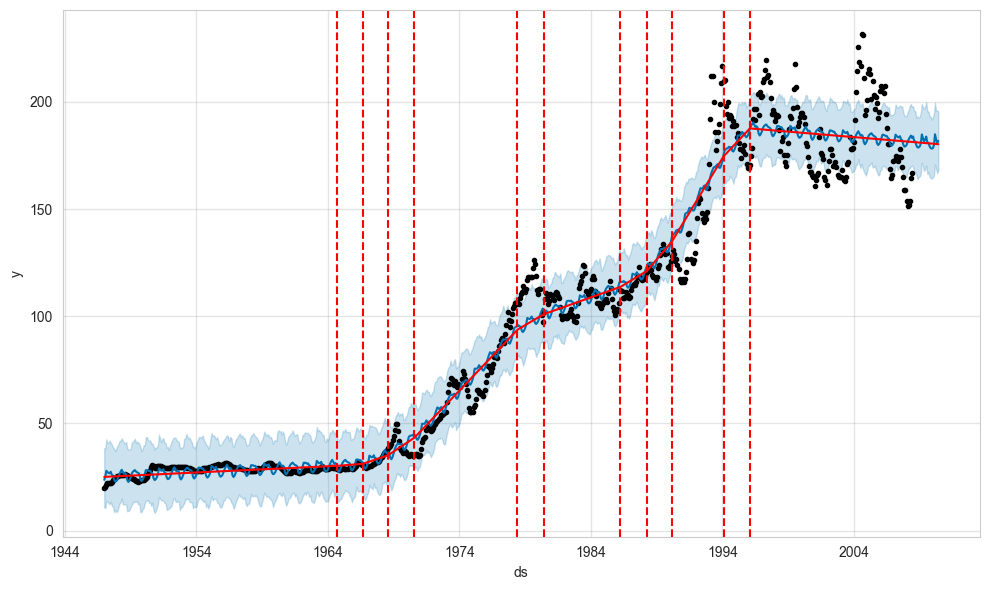

In [238]:
from prophet.plot import add_changepoints_to_plot


fig = model.plot(forecast)

# Add the changepoints to the plot
a = add_changepoints_to_plot(fig.gca(), model, forecast)

- The trend component fails to capture the trend beyond the point where changepoints conclude. Therefore, let’s attempt to broaden the distribution of changepoints from the beginning to the end.

[[<matplotlib.lines.Line2D at 0x1cc0496f590>],

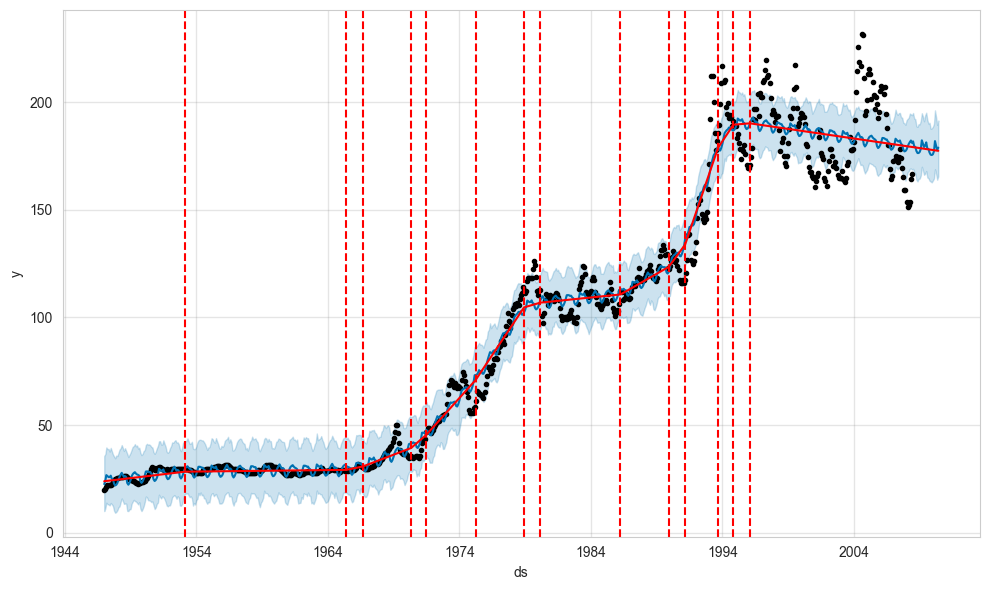

In [240]:
from prophet.plot import add_changepoints_to_plot
model2 = Prophet(
    n_changepoints=40,                 # Example: specify a different number of changepoints
    changepoint_range=.80,             # Example: use 90% of the data for changepoint detection
    changepoint_prior_scale=.15       # Example: set a lower prior scale for less flexible trend
)

# Fit the model to the data
model2.fit(train_prophet)

# Use the model to make predictions and plot the results
forecast2 = model2.predict(future)
fig = model2.plot(forecast2)
add_changepoints_to_plot(fig.gca(), model2, forecast2)

By raising the number of changepoints to 38, changepoint_range to .99 and the changepoint prior scale to 0.15, we have improved the detection of changepoints compared to earlier attempts.

#### Section 3.3

Assessment of whether the model should take into account a saturating minimum/maximum point

- Lumber price can increase/decrease to any limit, hence this time series follows linear trend not logistics trend.

- Because of the same reason, keeping cap or floor in the model is not advisable.

#### Section 3.4

Identification and assessment of seasonality (daily, weekly, yearly, as well as additive/multiplicative), to include visualizations, as appropriate

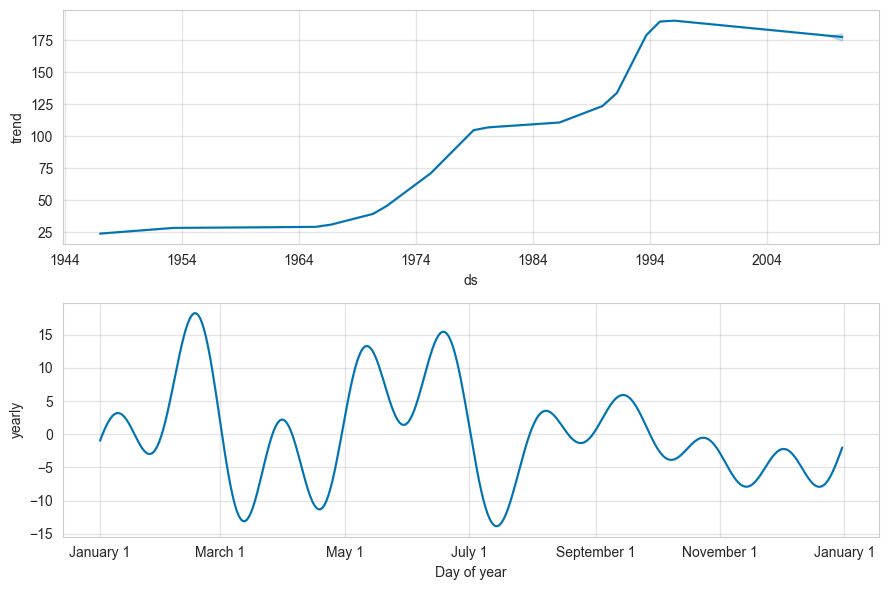

In [241]:
fig2 = model2.plot_components(forecast2)

plt.show()

- The yearly seasonality component shows a repeating annual pattern within the data.
- There’s a peak around the beginning of the year, a trough in the middle of the year, and another peak towards the end of the year.
- This suggests that the time series has a significant yearly seasonal component, with periods of higher and lower values corresponding to specific times of the year.

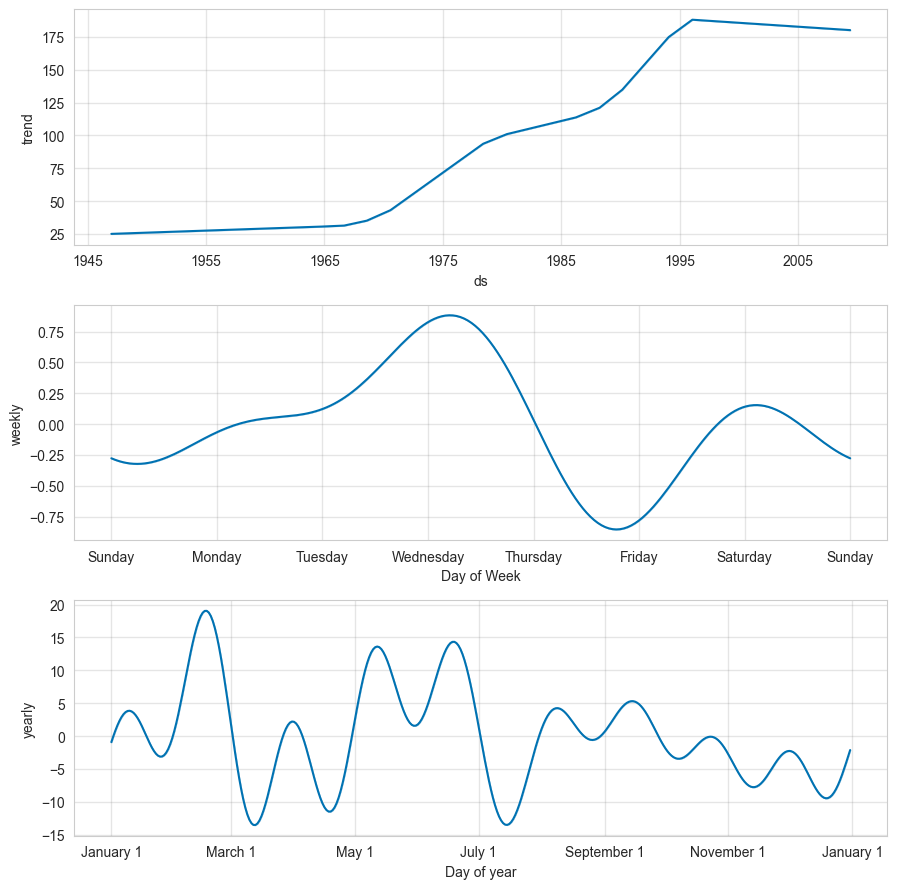

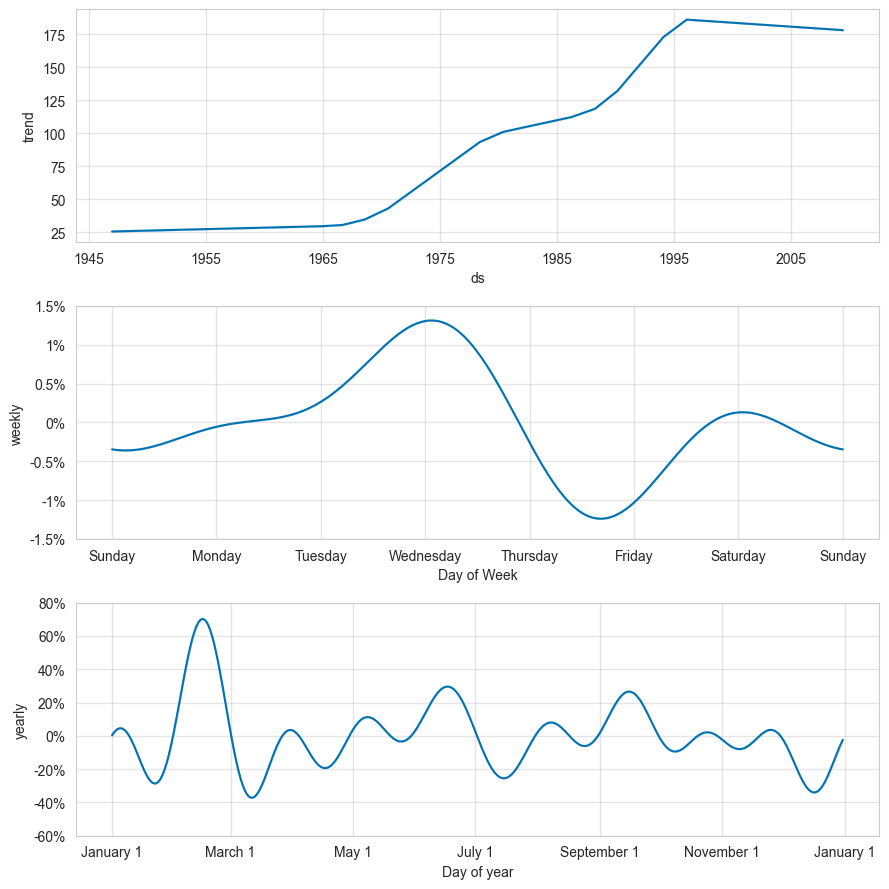

In [242]:
from prophet import Prophet
import pandas as pd
from prophet.plot import plot_yearly

# Assuming 'uc_page_views_train' is a pandas DataFrame with 'ds' and 'y' columns

# Initialize and fit the Prophet model with additive seasonality
additive_model = Prophet(seasonality_mode='additive')
additive_model.add_seasonality(name='yearly', period=365.25, fourier_order=10)
additive_model.add_seasonality(name='weekly', period=7, fourier_order=3)
additive_model.fit(train_prophet)

# Initialize and fit the Prophet model with multiplicative seasonality
multiplicative_model = Prophet(seasonality_mode='multiplicative')
multiplicative_model.add_seasonality(name='yearly', period=365.25, fourier_order=10)
multiplicative_model.add_seasonality(name='weekly', period=7, fourier_order=3)
multiplicative_model.fit(train_prophet)

# Create future dataframes for both models
future = additive_model.make_future_dataframe(periods=365)  # adjust periods as needed

# Make predictions with both models
forecast_additive = additive_model.predict(future)
forecast_multiplicative = multiplicative_model.predict(future)

# Plot the components of the additive model
fig1 = additive_model.plot_components(forecast_additive)

# Plot the components of the multiplicative model
fig2 = multiplicative_model.plot_components(forecast_multiplicative)

# Depending on your environment, you may need to show the plots explicitly
import matplotlib.pyplot as plt
plt.show()

- If we observe the magnitude of the yearly seasonal fluctuations, they appear relatively consistent over time and do not seem to change proportionally with the increasing trend. This observation suggest that the seasonality is <b>additive.

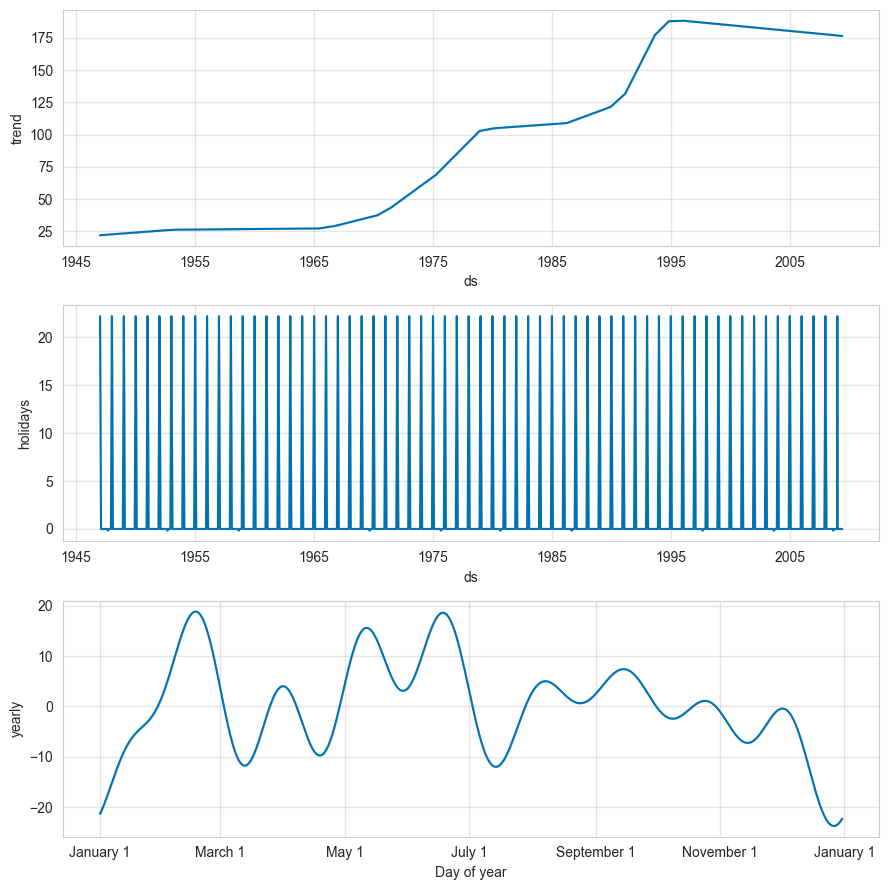

In [243]:
model3 = Prophet(growth='linear', seasonality_mode='additive',changepoint_range= .80, n_changepoints=40,changepoint_prior_scale = 0.15)
model3.add_country_holidays(country_name='US')
model3.fit(train_prophet)


# Create future dataframes for both models
future = model3.make_future_dataframe(periods=365)  # adjust periods as needed

# Make predictions with both models
forecast_orig = model2.predict(future)
forecast_w_holidays = model3.predict(future)

# To compare components, we use plot_components method from Prophet
from prophet.plot import plot_components

# Plot the components of the original model
#fig1 = plot_components(model2, forecast_orig)

# Plot the components of the model with holidays
fig2 = plot_components(model3, forecast_w_holidays)

# Depending on your environment, you may need to show the plots explicitly
import matplotlib.pyplot as plt
plt.show()

- It seems to indicate consistent negative impacts on the metric being measured on specific dates, which are likely corresponding to holiday events. The consistent presence of these impacts across many years suggests that holidays have a systematic effect on the time series.

### Section 4 - Model Comparison and Validation
The final section is focused on assessing and comparing the performance of several models proposed above, to include, at a minimum, one ARIMA model, one Prophet model, and one naive model. You are welcome to compare additional model specifications/hyperparameter combinations during cross-validation as well. This section should include, but is not necessarily limited to:

- Selection and implementation of an appropriate rolling window cross-validation scheme on the training set comparing a naive forecast (naive, naive with drift, or seasonal naive), the best ARIMA model from above, and an appropriate Prophet model. Additional model specifications may also be compared.

- Compare the performance of the models, and identify which model performs the best at a certain forecasting horizon (e.g.t+1, t+2, etc.)

- Assess the performance of the forecast from the best, selected model on the test set and discuss the performance results

- Finally, refit the best model to all of the data (including train and test set), and produce a forecast for a meaningful period of time in the future (e.g. 6 months or 1 year). Discuss the forecast and any potential issues with the forecast.

#### Section 4.1

Selection and implementation of an appropriate rolling window cross-validation scheme on the training set comparing a naive forecast (naive, naive with drift, or seasonal naive), the best ARIMA model from above, and an appropriate Prophet model. Additional model specifications may also be compared.

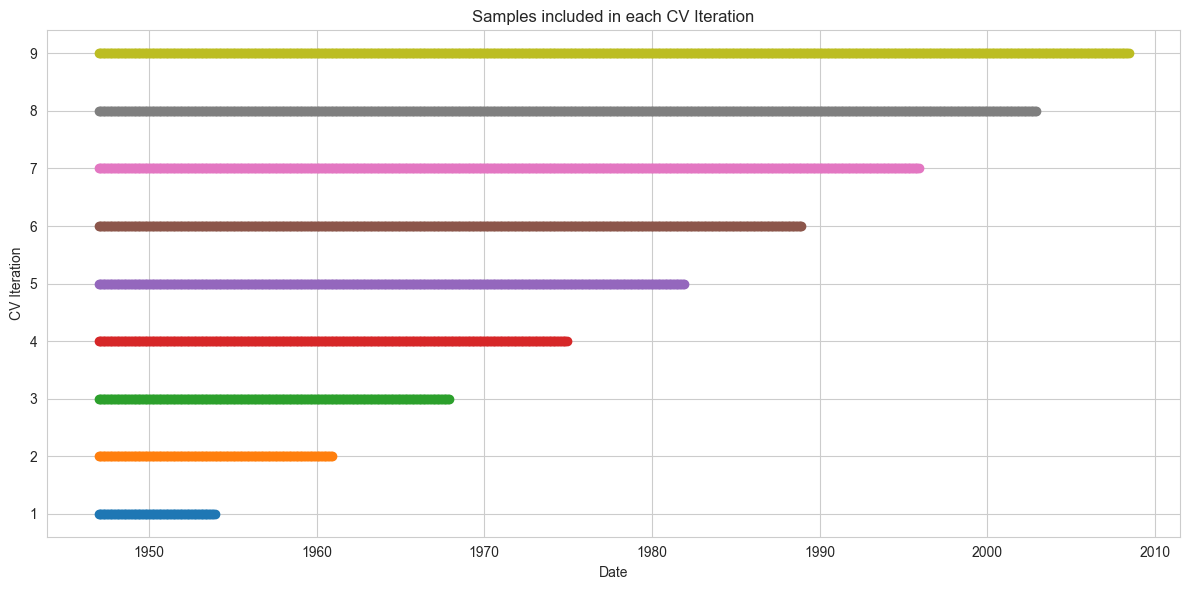

In [250]:
gaps = 12 * 7

train['id'] = 0

for id, start_index in enumerate(range(0, train.shape[0], gaps)):
    end_index = min(start_index + gaps, train.shape[0])
    train['id'][start_index:end_index] = id + 1
plt.figure(figsize=(12, 6))

for i in train['id'].unique():
    
    lst = np.arange(1,i+1)
    X = train[train['id'].isin(lst)]['date']
    Y = [i] * len(X)
    
    plt.scatter(X, Y, cmap='viridis')


plt.xlabel('Date')
plt.ylabel('CV Iteration')
plt.title('Samples included in each CV Iteration')

plt.tight_layout()
plt.show()

In [256]:
import warnings
warnings.filterwarnings("ignore")
from copy import deepcopy


import logging
from cmdstanpy import CmdStanModel

logging.getLogger('cmdstanpy').setLevel(logging.WARNING)
col = 'lumber_price'
forecast_periods = 24

test_sets = dict()
arima_pred = dict()
naive_pred = dict()
prophet_pred = dict()

metrics_df = pd.DataFrame(columns=['CV ID','metric','ARIMA','Naive_WD','Prophet'])


train_data = deepcopy(train.rename(columns={'date':'ds',
                                           'lumber_price':'y'}))

test_data  = deepcopy(lumber.rename(columns={'date':'ds',
                                           'lumber_price':'y'}))

for i, cv_id in enumerate(train['id'].unique()):
    
    ids = np.arange(1,cv_id+1)
    cv_train_data = train_data[train.id.isin(ids)]
    cv_test_data = test_data[len(cv_train_data):len(cv_train_data)+forecast_periods]
    
    arima_model = ARIMA(cv_train_data['log_lumber_price'], order=(2,1,0), seasonal_order=(0, 0, 0, 0)).fit()
    arima_forecasted_data = arima_model.get_forecast(steps=forecast_periods)
    arima_forecast = np.exp(arima_forecasted_data.predicted_mean)
    
    prophet_model = Prophet(changepoint_prior_scale=0.15, changepoint_range=.80, n_changepoints=40).add_country_holidays(country_name='US')
    prophet_model.fit(cv_train_data[['ds','y']])
    prophet_forecast = prophet_model.predict(cv_test_data[['ds']])
        
    drift = (cv_train_data['y'][len(cv_train_data)-1] - cv_train_data['y'][0])/(len(cv_train_data)-1)
    lagged_val = cv_train_data['y'][len(cv_train_data)-1]
    naive_forecast = [(lagged_val + (i+1) * drift )for i in range(0, forecast_periods)]
    
    test_sets[cv_id] = cv_test_data['ds']
    arima_pred[cv_id] = arima_forecast
    naive_pred[cv_id] = naive_forecast
    prophet_pred[cv_id] = prophet_forecast
    
    actual = cv_test_data['y'].values
    
    metrics_df.loc[len(metrics_df)] = [cv_id, "RMSE", 
                                       np.sqrt(mean_squared_error(actual, arima_forecast)),
                                       np.sqrt(mean_squared_error(actual, naive_forecast)),
                                       np.sqrt(mean_squared_error(actual, prophet_forecast['yhat']))]
    
    metrics_df.loc[len(metrics_df)] = [cv_id, "MAE", 
                                       mean_absolute_error(actual, arima_forecast),
                                       mean_absolute_error(actual, naive_forecast),
                                       mean_absolute_error(actual, prophet_forecast['yhat'])]
    
    metrics_df.loc[len(metrics_df)] = [cv_id, "MAPE", 
                                       np.mean(np.abs((actual - arima_forecast) / actual)) * 100,
                                       np.mean(np.abs((actual- naive_forecast) / actual)) * 100,
                                       np.mean(np.abs((actual - prophet_forecast['yhat']) / actual)) * 100]
    
    metrics_df.loc[len(metrics_df)] = [cv_id, "MASE", 
                                       mean_absolute_error(actual, arima_forecast) / mean_absolute_error(actual, naive_forecast),
                                       mean_absolute_error(actual, naive_forecast) / mean_absolute_error(actual, naive_forecast),
                                       mean_absolute_error(actual, prophet_forecast['yhat']) / mean_absolute_error(actual, naive_forecast)]

    
    

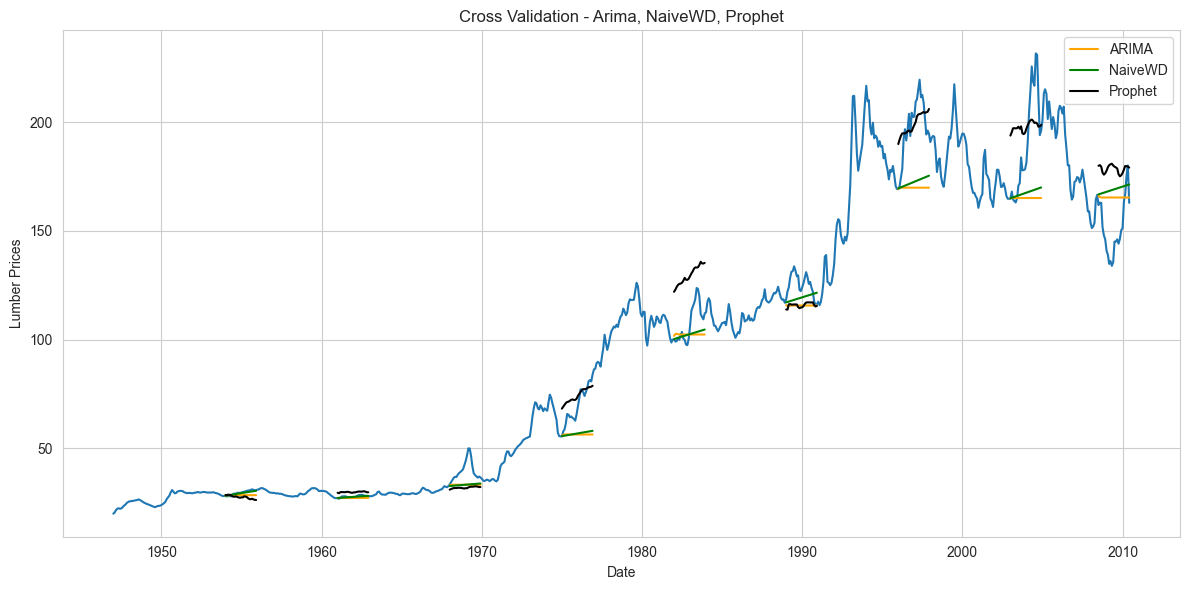

In [257]:
plot_data = lumber.iloc[:len(train)+forecast_periods]

plt.figure(figsize=(12, 6))
plt.plot(plot_data['date'],plot_data['lumber_price'], label = 'Original Time Series')

handles = []
for id in train['id'].unique():
    arima_line, = plt.plot(test_sets[id], arima_pred[id], color = 'orange')
    naive_line, = plt.plot(test_sets[id], naive_pred[id], color = 'green')
    prophet_line, = plt.plot(test_sets[id], prophet_pred[id]['yhat'], color = 'black')
    
    handles.extend([arima_line, naive_line, prophet_line])

plt.legend(handles=handles, labels=['ARIMA', 'NaiveWD', 'Prophet'])

plt.plot()
plt.xlabel('Date')
plt.ylabel('Lumber Prices')
plt.title("Cross Validation - Arima, NaiveWD, Prophet")
plt.tight_layout()
plt.show()


#### Section 4.2

Compare the performance of the models, and identify which model performs the best at a certain forecasting horizon (e.g.t+1, t+2, etc.)

In [258]:
metrics_df

,CV ID,metric,ARIMA,Naive_WD,Prophet
0,1,RMSE,1.550796,0.504359,2.697515
1,1,MAE,1.336913,0.458785,2.281983
2,1,MAPE,4.450196,1.552015,7.585192
3,1,MASE,2.914028,1.000000,4.973970
4,2,RMSE,0.787692,0.414852,2.126466
5,2,MAE,0.644608,0.362899,2.095776
6,2,MAPE,2.301779,1.307992,7.604965
7,2,MASE,1.776274,1.000000,5.775090
8,3,RMSE,7.968374,7.915264,9.056221
9,3,MAE,6.540155,6.525863,7.865262


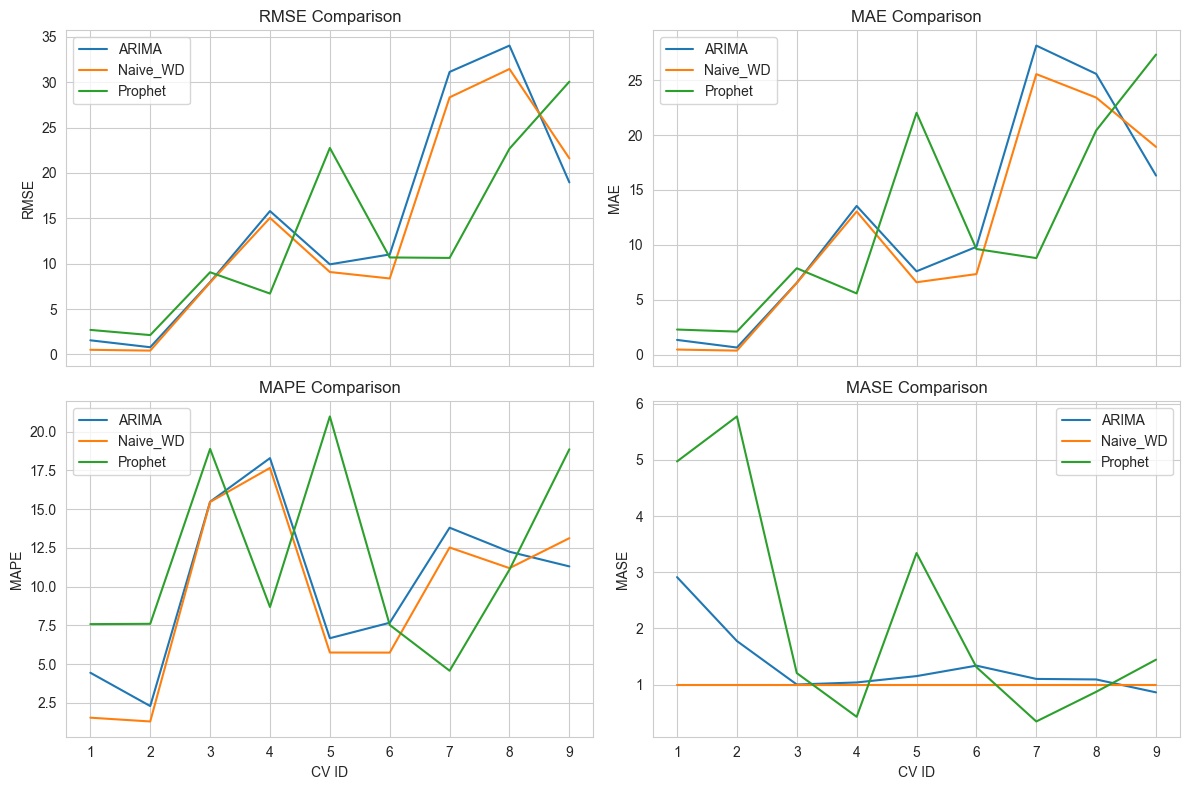

In [259]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

metrics = ['RMSE', 'MAE', 'MAPE', 'MASE']
models = ['ARIMA', 'Naive_WD', 'Prophet']

for i, metric in enumerate(metrics):
    row, col = divmod(i, 2)
    ax = axes[row, col]
    for model in models:
        df_model = metrics_df[metrics_df['metric'] == metric]
        sns.lineplot(x='CV ID', y=model, data=df_model, label=model, ax=ax)

    ax.set_title(f'{metric} Comparison')
    ax.set_ylabel(metric)
    ax.set_xlabel('CV ID')
    ax.legend()

plt.tight_layout()
plt.show()

In [260]:
metrics_df.groupby('metric').agg({'ARIMA':'mean', 'Naive_WD':'mean', 'Prophet':'mean'})

,ARIMA,Naive_WD,Prophet
metric,,,
MAE,12.166053,11.353915,11.777065
MAPE,10.247432,9.369846,11.756184
MASE,1.364145,1.000000,2.188520
RMSE,14.579016,13.639526,13.047644


By comparing performance matrices for all the model, we know Naive model with drift is performing better than Prophet and ARIMA.

#### Section 4.3

Assess the performance of the forecast from the best, selected model on the test set and discuss the performance results.

In [264]:
drift = (train['lumber_price'][len(train_data)-1] - train['lumber_price'][0])/(len(train)-1)
lagged_val = train['lumber_price'][len(train)-1]
naive_forecast = [(lagged_val + (i+1) * drift )for i in range(0, len(test))]

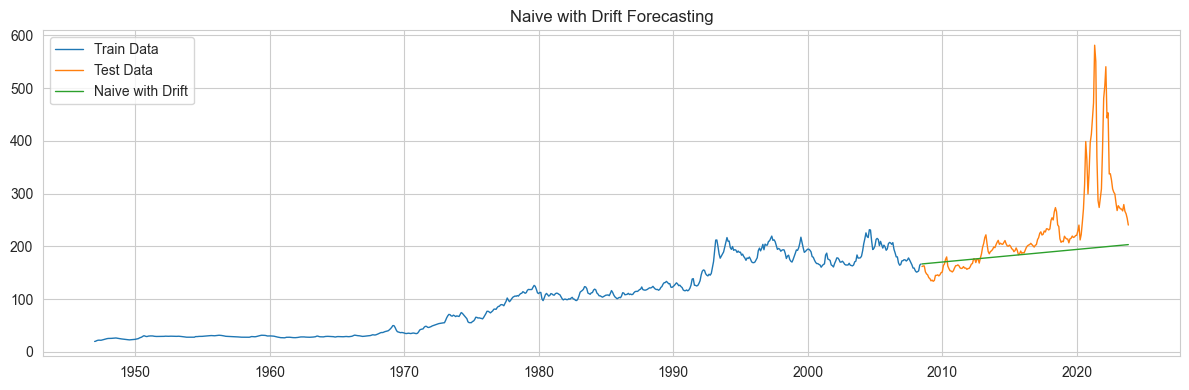

In [265]:
plt.figure(figsize=(12, 4))

plt.plot(train['date'], train['lumber_price'], label='Train Data', linewidth=1)
plt.plot(test['date'], test['lumber_price'], label='Test Data', linewidth=1)
plt.plot(test['date'],naive_forecast , label='Naive with Drift', linewidth=1)

plt.legend()
plt.title("Naive with Drift Forecasting")
plt.tight_layout()
plt.show()

#### Section 4.4

Finally, refit the best model to all of the data (including train and test set), and produce a forecast for a meaningful period of time in the future (e.g. 6 months or 1 year). Discuss the forecast and any potential issues with the forecast.

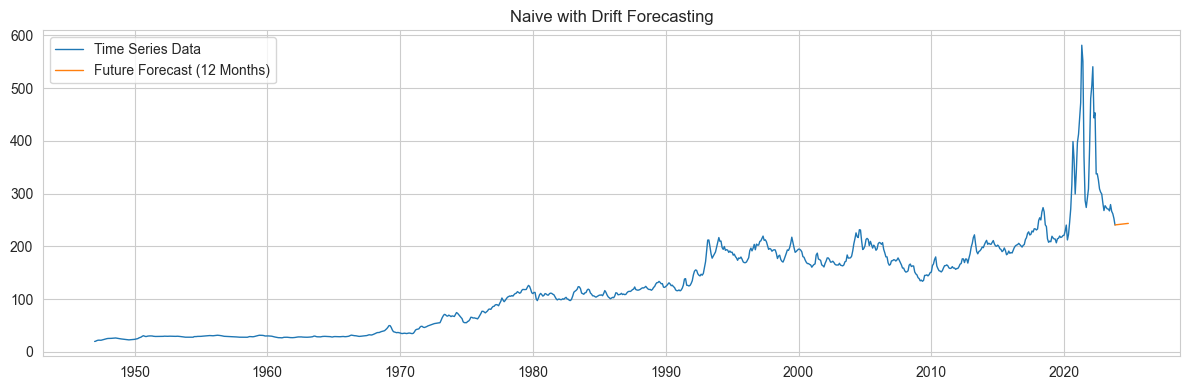

In [266]:
drift = (lumber['lumber_price'][len(lumber)-1] - lumber['lumber_price'][0])/(len(lumber)-1)
lagged_val = lumber['lumber_price'][len(lumber)-1]
naive_forecast = [(lagged_val + (i+1) * drift )for i in range(0, 13)]
future_dates = pd.date_range(lumber['date'].max(), periods=13, freq='MS')


plt.figure(figsize=(12, 4))

plt.plot(lumber['date'], lumber['lumber_price'], label='Time Series Data', linewidth=1)
plt.plot(future_dates, naive_forecast , label='Future Forecast (12 Months)', linewidth=1)

plt.legend()
plt.title("Naive with Drift Forecasting")
plt.tight_layout()
plt.show()

Potential Issue:
    
- Sensitivity to the time span of data: The drift is calculated from the very first and last points, meaning that if the historical data covers a long period with structural changes in the market, the forecast may not be representative of the current market dynamics.

- Economic and external factors: The model does not consider any external factors such as economic changes, market demand, supply constraints, or policy changes that could significantly affect lumber prices.

- Confidence intervals: The plot does not include confidence intervals. In reality, there is always uncertainty associated with forecasts, and it is helpful to know the range within which the actual future values are likely to fall.